In [8]:
from datasets import load_dataset

ds = load_dataset("Nellyw888/RTL-Coder_7b_reasoning")
print(ds)

DatasetDict({
    train: Dataset({
        features: ['id', 'instruction', 'output'],
        num_rows: 1300
    })
})


In [9]:
#ds['train'][:]#[:3]

print(ds['train'][:])  # now it's safe to access an example

{'id': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '159', '

In [35]:
from pathlib import Path
import pandas as pd
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from copy import copy
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import json
import sys
# Add the 'code' directory to sys.path
project_path = Path(
    '/home/ec2-user/SageMaker/david/tdm-sentiment/'
)
data_path = project_path / 'data/'
data_sample = Path('/home/ec2-user/SageMaker/data/')
dataset_name = 'LosAngelesTimesDavid' # 'USATodayDavid' 'ChicagoTribune' 'TheWashingtonPostDavid' Newyork20042023' LosAngelesTimesDavid 
sys.path.append(str(project_path / 'code'))

# Import custom modules
from tdm_parser.tdm_parser import TdmXmlParser
from salience_index import SalienceScorer

In [36]:
def get_all_csv_files(folder_path):
    # Use Path to find all CSV files in the folder
    csv_files = list(Path(folder_path).glob('*.csv'))
    return csv_files



def concat_csv_files(folder_path):
    # Get a list of all CSV files in the folder
    csv_files = get_all_csv_files(folder_path)
    
    # Initialize an empty list to store DataFrames
    df_list = []
    
    # Loop through the list of CSV files
    for file in csv_files:
        # Read each CSV file into a DataFrame
        df = pd.read_csv(file)
        
        # Append the DataFrame to the list
        df_list.append(df)
    
    # Concatenate all DataFrames in the list into a single DataFrame
    combined_df = pd.concat(df_list, ignore_index=True)
    
    return combined_df



folder_path = data_path / 'results/' / dataset_name #TODO

# Combine CSV files from both folders
combined_df = concat_csv_files(folder_path)

# Drop duplicate rows based on the 'GOID' column
combined_df = combined_df.drop_duplicates(subset=['GOID'])

# Combine 'International Herald Tribune' and 'New York Times' into one category
combined_df['Publisher'] = combined_df['Publisher'].replace(
    {'international herald tribune': 'new york times',
     'new york times the': 'new york times',
     'international new york times': 'new york times',
     'los angeles times (pre-1997 fulltext)': 'los angeles times',
     'washington post (pre-1997 fulltext) the': 'washington post the',
     'usa today (online)': 'usa today'}
)

combined_df = combined_df[combined_df['Publisher'] != 'new york times español']
combined_df.head() #

,WordCount,GOID,Publisher,Date,Section,Type,Tags,Page,is_economic,bert_sentiment
0,573,421420408,los angeles times,1998-07-14,metro; part-b; metro desk,news,NaN,1,1,-0.607066
1,663,422153514,los angeles times,2008-01-01,main news; part a; national desk,news,federal government,a.10,1,-0.009481
2,432,422148727,los angeles times,2007-04-06,main news; part a; foreign desk,news,cruise lines,a.9,1,-0.303100
3,829,421577474,los angeles times,1999-11-17,business; part- c; financial desk,news,NaN,3,1,-0.544562
4,1033,293190162,los angeles times,1995-10-18,metro; part-b; no desk,news,NaN,1,1,-0.386170


In [37]:
# Count unique values in 'Page' column
unique_pages = combined_df['Page'].value_counts()
print(f'number of unique pag tags is: {len(unique_pages)}')
print(unique_pages[:10])


number of unique pag tags is: 1082
Page
1      44914
3      41987
2      40304
b.1    30618
b.3    29004
4      24000
c.2    23510
c.3    22173
c.1    21346
a.1    21083
Name: count, dtype: int64


In [38]:
# Initialize the Salience Scorer
salience = SalienceScorer()

# Copy the combined dataframe
df = copy(combined_df)

# Ensure 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Step 1: Filter out invalid page entries
invalid_pages = {'asnap', 'nan'}
df = df[~df['Page'].astype(str).str.lower().isin(invalid_pages)]
df = df[df['Page'].astype(str).str.split('.').apply(len).isin([1, 2])]

# Step 2: Normalize page names and remove any NaN entries in 'Page' column
df['Page'] = df['Page'].apply(salience.normalize_page)
df = df.dropna(subset=['Page'])

# Step 3: Calculate total word count and occurrences per page and date
page_word_sums = (
    df.groupby(['Date', 'Page'])['WordCount']
    .agg(['sum', 'count'])
    .reset_index()
)

# Step 4: Calculate weighted mean words per page
# First, multiply word count by count (number of articles)
page_word_sums['weighted_sum'] = page_word_sums['sum'] * page_word_sums['count']

# Calculate weighted mean for each page
weighted_mean_words_per_page = (
    page_word_sums.groupby('Page').apply(lambda x: x['weighted_sum'].sum() / x['count'].sum())
    .reset_index(name='WeightedMeanWordsPerPage')
)

# Step 5: Calculate total page appearance count
total_page_count = (
    df.groupby('Page').size()
    .reset_index(name='Count')
)

# Step 6: Filter pages with at least 20 occurrences
total_page_count = total_page_count[total_page_count['Count'] >= 20]

# Step 7: Merge weighted mean word count and total page count for filtered pages
page_stats = pd.merge(weighted_mean_words_per_page, total_page_count, on='Page')

# Step 8: Create dictionary with Max and count values for filtered pages
page_size_dict = page_stats.set_index('Page').to_dict(orient='index')

# Convert page numbers to strings for JSON keys
page_size_dict = {str(key): value for key, value in page_size_dict.items()}

# Define file path and create directories if necessary
file_path = data_path / f"newspaper_page_sizes/{dataset_name}.json"
file_path.parent.mkdir(parents=True, exist_ok=True)

# Write the dictionary to a JSON file
with file_path.open('w', encoding='utf-8') as f:
    json.dump(page_size_dict, f, ensure_ascii=False, indent=4)
    print(f"Stored page sizes for {dataset_name} in {file_path}")
    


Stored page sizes for LosAngelesTimesDavid in /home/ec2-user/SageMaker/david/tdm-sentiment/data/newspaper_page_sizes/LosAngelesTimesDavid.json


/tmp/ipykernel_22362/2982458411.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  page_word_sums.groupby('Page').apply(lambda x: x['weighted_sum'].sum() / x['count'].sum())


In [39]:
df.head()
publisher = df['Publisher'][1]

# Calculate weighted average
weighted_average = (page_stats['WeightedMeanWordsPerPage'] * page_stats['Count']).sum() / page_stats['Count'].sum()

# Calculate median
median_word_count = page_stats['WeightedMeanWordsPerPage'].median()

# Calculate unweighted average
average_word_count = page_stats['WeightedMeanWordsPerPage'].mean()

print(f"The weighted average word count per Page in the {publisher} is {round(weighted_average)}")
print(f"The median word count per Page in the {publisher} is {round(median_word_count)}")
print(f"The average (unweighted) word count per Page in the {publisher} is {round(average_word_count)}")


The weighted average word count per Page in the los angeles times is 4012
The median word count per Page in the los angeles times is 771
The average (unweighted) word count per Page in the los angeles times is 1026


/tmp/ipykernel_22362/3304934009.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Page', y='MeanWords', data=df, palette='viridis')


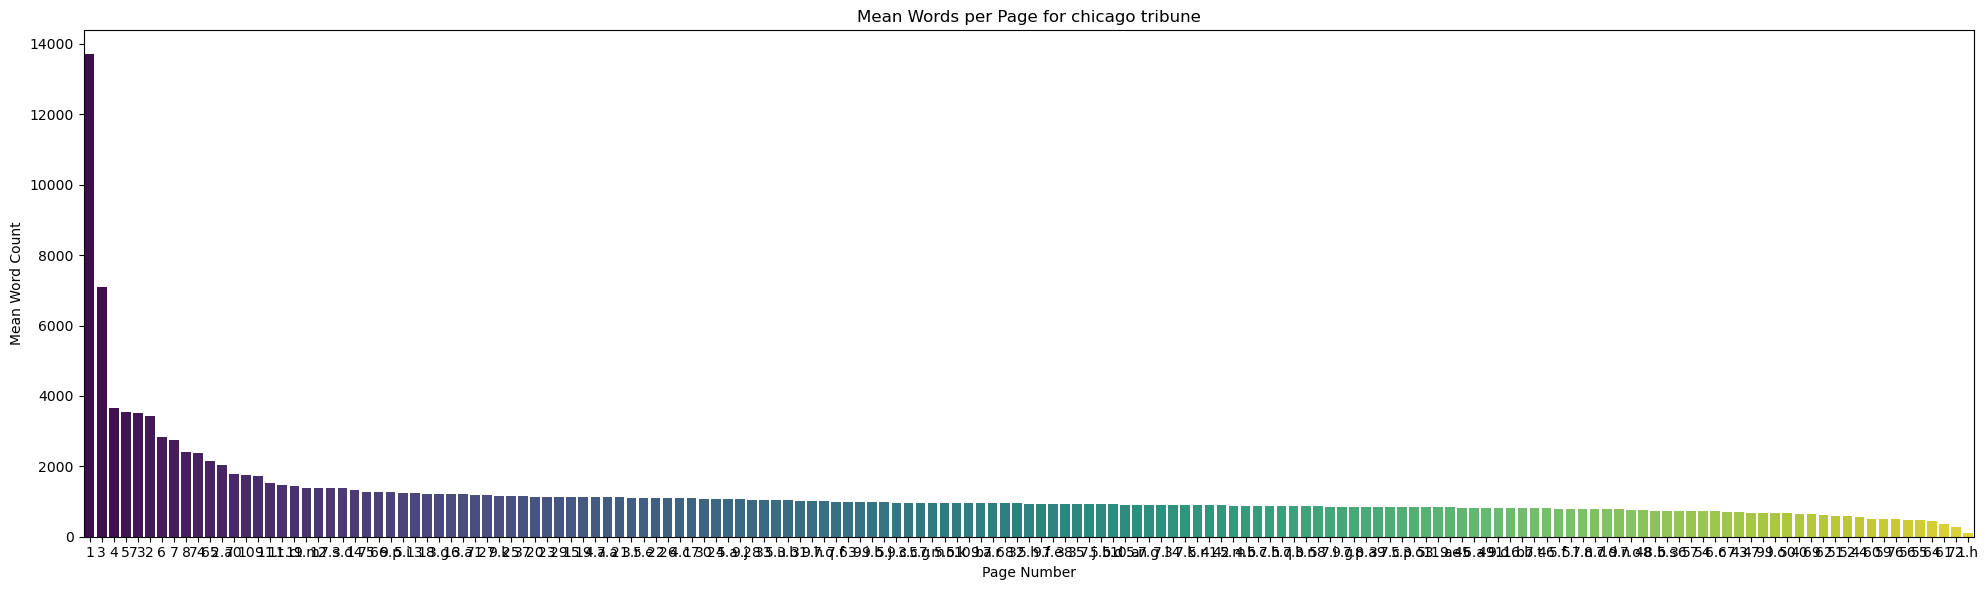

In [12]:


# Convert page_size_dict to DataFrame and sort by 'AverageWords' descending
df = pd.DataFrame.from_dict(page_size_dict, orient='index').reset_index()
df.columns = ['Page', 'MeanWords', 'Count']
df = df.sort_values(by='MeanWords', ascending=False)
#df = df[0:100]

# Plot using Matplotlib and Seaborn
plt.figure(figsize=(20, 6))
sns.barplot(x='Page', y='MeanWords', data=df, palette='viridis')

# Add titles and labels
plt.title(f'Mean Words per Page for {publisher}') #TODO
plt.xlabel('Page Number')
plt.ylabel('Mean Word Count')

# Annotate bars with values
#for index, row in df.iterrows():
    #plt.text(index, row.AverageWords + 10, f"{row.AverageWords:.0f}", ha='center')

plt.tight_layout()
plt.show()




In [98]:
df

,Page,MaxWords,Count
49,4,286385,41353
94,6,246125,37266
0,1,208237,103152
63,5,205990,36707
30,3,188347,98485
...,...,...,...
128,7.t,1123,26
154,9.n,1118,26
152,9.l,1093,31
155,9.o,942,20
